In [43]:
!pip install wfdb PyWavelets -q


In [44]:
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from scipy import stats
import wfdb
import os
from datetime import datetime

# Default parameters for signal processing
DEFAULT_PARAMS = {
    'sampling_rate': 500,
    'lowcut': 1.0,
    'highcut': 30.0,
    'filter_order': 3,
    'peak_detection': {
        'min_distance_factor': 0.4,  # multiplied by sampling_rate
        'height_std_factor': 2,      # multiplied by signal std
        'prominence_factor': 1        # multiplied by signal std
    },
    'rr_validation': {
        'min_rr': 0.4,  # minimum RR interval in seconds (150 bpm)
        'max_rr': 1.5,  # maximum RR interval in seconds (40 bpm)
        'iqr_factor': 1.5  # factor for IQR-based outlier detection
    }
}

class HolterMetricsAnalyzer:
    def __init__(self, params=None):
        """
        Initialize analyzer with custom parameters
        params: dictionary with configuration parameters. If None, uses DEFAULT_PARAMS
        """
        self.params = DEFAULT_PARAMS.copy()
        if params:
            self._update_params(params)

        self.record_name = None
        self.signal_data = None
        self.header_info = None
        self.qrs_annotations = None
        self.atr_annotations = None

    def _update_params(self, new_params):
        """Update parameters with new values, maintaining nested structure"""
        for key, value in new_params.items():
            if isinstance(value, dict) and key in self.params:
                self.params[key].update(value)
            else:
                self.params[key] = value

    def load_holter_data(self, record_path):
        """
        Carrega todos os arquivos do Holter (.dat, .atr, .hea, .qrs)
        record_path: caminho do arquivo sem extensão
        """
        try:
            # Verifica se os arquivos necessários existem
            required_extensions = ['.dat', '.hea']
            for ext in required_extensions:
                if not os.path.exists(record_path + ext):
                    raise FileNotFoundError(f"Arquivo {record_path + ext} não encontrado")

            # Carrega o sinal e informações do cabeçalho
            self.record_name = os.path.basename(record_path)
            signal_temp, fields = wfdb.rdsamp(record_path)

            self.signal_data = signal_temp
            self.header_info = fields

            # Atualiza a taxa de amostragem com base no arquivo
            if isinstance(fields, dict):
                self.params['sampling_rate'] = fields.get('fs', 200)
            else:
                self.params['sampling_rate'] = getattr(fields, 'fs', 200)

            # Tenta carregar anotações QRS se existirem
            try:
                self.qrs_annotations = wfdb.rdann(record_path, 'qrs')
            except Exception as e:
                print(f"Aviso: Arquivo QRS não encontrado ou inválido: {e}")

            # Tenta carregar anotações ATR se existirem
            try:
                self.atr_annotations = wfdb.rdann(record_path, 'atr')
            except Exception as e:
                print(f"Aviso: Arquivo ATR não encontrado ou inválido: {e}")

            return True

        except Exception as e:
            print(f"Erro ao carregar arquivos Holter: {e}")
            return False

    def bandpass_filter(self, data):
        """Aplica filtro passa-banda aos dados."""
        try:
            nyq = 0.5 * self.params['sampling_rate']
            low = self.params['lowcut'] / nyq
            high = self.params['highcut'] / nyq
            b, a = butter(self.params['filter_order'], [low, high], btype='band')
            filtered = filtfilt(b, a, data)
            filtered = (filtered - np.mean(filtered)) / np.std(filtered)
            return filtered
        except Exception as e:
            print(f"Erro ao aplicar filtro: {e}")
            return None

    def detect_peaks(self, filtered_data):
        """Detecta picos R com validação."""
        try:
            min_distance = int(self.params['peak_detection']['min_distance_factor'] *
                             self.params['sampling_rate'])
            height = (np.mean(filtered_data) +
                     self.params['peak_detection']['height_std_factor'] *
                     np.std(filtered_data))
            prominence = (self.params['peak_detection']['prominence_factor'] *
                        np.std(filtered_data))

            peaks, _ = find_peaks(filtered_data,
                                distance=min_distance,
                                height=height,
                                prominence=prominence)

            if len(peaks) < 2:
                return None

            return peaks

        except Exception as e:
            print(f"Erro na detecção de picos: {e}")
            return None

    def validate_rr_intervals(self, rr_intervals):
        """Valida intervalos RR."""
        if len(rr_intervals) < 2:
            return None

        # Limites fisiológicos
        valid_mask = ((rr_intervals >= self.params['rr_validation']['min_rr']) &
                     (rr_intervals <= self.params['rr_validation']['max_rr']))
        valid_rr = rr_intervals[valid_mask]

        if len(valid_rr) < 2:
            return None

        # Remover outliers estatísticos
        q1, q3 = np.percentile(valid_rr, [25, 75])
        iqr = q3 - q1
        iqr_factor = self.params['rr_validation']['iqr_factor']
        lower = q1 - iqr_factor * iqr
        upper = q3 + iqr_factor * iqr

        return valid_rr[(valid_rr >= lower) & (valid_rr <= upper)]

    def calculate_basic_metrics(self, peaks, duration):
        """Calcula métricas básicas."""
        rr_intervals = np.diff(peaks) / self.params['sampling_rate']
        valid_rr = self.validate_rr_intervals(rr_intervals)

        if valid_rr is None:
            return None

        heart_rates = 60 / valid_rr

        return {
            'duration': duration,
            'total_beats': len(peaks),
            'valid_beats': len(valid_rr) + 1,
            'mean_hr': np.mean(heart_rates),
            'std_hr': np.std(heart_rates),
            'min_hr': np.min(heart_rates),
            'max_hr': np.max(heart_rates),
            'hr_range': np.max(heart_rates) - np.min(heart_rates)
        }

    def calculate_hrv_metrics(self, rr_intervals):
        """Calcula métricas de VFC."""
        valid_rr = self.validate_rr_intervals(rr_intervals)
        if valid_rr is None:
            return None

        rr_diff = np.diff(valid_rr)

        rmssd = np.sqrt(np.mean(rr_diff ** 2)) * 1000
        sdnn = np.std(valid_rr) * 1000
        nn50 = sum(abs(rr_diff) > 0.05)
        pnn50 = (nn50 / len(rr_diff)) * 100 if len(rr_diff) > 0 else 0

        return {
            'rmssd': rmssd,
            'sdnn': sdnn,
            'nn50': nn50,
            'pnn50': pnn50
        }

    def calculate_nonlinear_metrics(self, rr_intervals):
        """Calcula métricas não-lineares."""
        valid_rr = self.validate_rr_intervals(rr_intervals)
        if valid_rr is None:
            return None

        rr_diff = np.diff(valid_rr)

        sd1 = np.std(rr_diff / np.sqrt(2)) * 1000
        sd2 = np.std(valid_rr) * 1000

        return {
            'sd1': sd1,
            'sd2': sd2,
            'sd_ratio': sd1/sd2 if sd2 > 0 else 0
        }

    def get_header_info(self):
        """Retorna informações do cabeçalho do arquivo."""
        if self.header_info is None:
            return None

        # Obtém valores com fallbacks seguros
        sampling_rate = self.params['sampling_rate']
        n_sig = self.header_info.get('n_sig', 1) if isinstance(self.header_info, dict) else getattr(self.header_info, 'n_sig', 1)
        sig_name = self.header_info.get('sig_name', ['ECG']) if isinstance(self.header_info, dict) else getattr(self.header_info, 'sig_name', ['ECG'])
        units = self.header_info.get('units', ['mV']) if isinstance(self.header_info, dict) else getattr(self.header_info, 'units', ['mV'])
        comments = self.header_info.get('comments', []) if isinstance(self.header_info, dict) else getattr(self.header_info, 'comments', [])

        # Tenta extrair data e hora dos comentários
        start_date = None
        start_time = None

        for comment in comments:
            if 'Date:' in comment:
                start_date = comment.split('Date:')[1].strip()
            if 'Time:' in comment:
                start_time = comment.split('Time:')[1].strip()

        # Calcula a duração
        duration = len(self.signal_data) / sampling_rate if self.signal_data is not None else 0

        return {
            'record_name': self.record_name,
            'sampling_rate': sampling_rate,
            'n_sig': n_sig,
            'signal_names': sig_name,
            'units': units,
            'duration': duration,
            'comments': comments,
            'start_date': start_date,
            'start_time': start_time
        }

    def get_qrs_info(self):
        """Retorna informações das anotações QRS."""
        if self.qrs_annotations is None:
            return None

        return {
            'total_beats': len(self.qrs_annotations.sample),
            'beat_locations': self.qrs_annotations.sample,
            'beat_types': self.qrs_annotations.symbol
        }

    def print_exam_info(self):
        """Imprime informações do exame Holter."""
        if self.header_info is None:
            print("Nenhum exame carregado.")
            return

        print("\n=== INFORMAÇÕES DO EXAME HOLTER ===")
        print("-" * 40)

        try:
            header_info = self.get_header_info()

            # Data e Hora do exame
            if header_info['start_date'] or header_info['start_time']:
                print("Data do exame:", header_info['start_date'] if header_info['start_date'] else "Não disponível")
                print("Hora do exame:", header_info['start_time'] if header_info['start_time'] else "Não disponível")

            # Informações básicas do registro
            print(f"\nNome do registro: {header_info['record_name']}")
            hours = header_info['duration'] / 3600
            minutes = (header_info['duration'] % 3600) / 60
            print(f"Duração do exame: {int(hours)}h {int(minutes)}min ({header_info['duration']:.2f} segundos)")
            print(f"Taxa de amostragem: {header_info['sampling_rate']} Hz")

            # Informações dos canais
            print(f"\nNúmero de canais: {header_info['n_sig']}")
            if header_info['signal_names']:
                print("Nomes dos canais:", ", ".join(header_info['signal_names']))
            if header_info['units']:
                print("Unidades:", ", ".join(header_info['units']))

            # Comentários do cabeçalho (podem conter informações adicionais)
            if header_info['comments'] and len(header_info['comments']) > 0:
                print("\nInformações adicionais:")
                for comment in header_info['comments']:
                    print(f"- {comment}")

            # Informações das anotações QRS se disponíveis
            qrs_info = self.get_qrs_info()
            if qrs_info:
                print(f"\nTotal de batimentos detectados: {qrs_info['total_beats']}")

        except Exception as e:
            print(f"Erro ao imprimir informações: {e}")

        print("-" * 40)

    def analyze_signal(self, data):
        """Realiza análise completa do sinal ECG."""
        try:
            filtered_data = self.bandpass_filter(data)
            if filtered_data is None:
                return None

            # Usa anotações QRS se disponíveis, senão detecta picos
            if self.qrs_annotations is not None:
                peaks = self.qrs_annotations.sample
            else:
                peaks = self.detect_peaks(filtered_data)

            if peaks is None or len(peaks) < 2:
                return None

            duration = len(filtered_data) / self.params['sampling_rate']
            rr_intervals = np.diff(peaks) / self.params['sampling_rate']
            valid_rr = self.validate_rr_intervals(rr_intervals)

            if valid_rr is None:
                return None

            basic_metrics = self.calculate_basic_metrics(peaks, duration)
            hrv_metrics = self.calculate_hrv_metrics(valid_rr)
            nonlinear_metrics = self.calculate_nonlinear_metrics(valid_rr)

            if None in [basic_metrics, hrv_metrics, nonlinear_metrics]:
                return None

            heart_rates = 60 / valid_rr
            hr_dist = {
                'bradycardia': np.sum(heart_rates < 60),
                'normal': np.sum((heart_rates >= 60) & (heart_rates < 100)),
                'tachycardia': np.sum(heart_rates >= 100)
            }

            return {
                'basic': basic_metrics,
                'hrv': hrv_metrics,
                'nonlinear': nonlinear_metrics,
                'hr_distribution': hr_dist,
                'peaks': peaks,
                'filtered_data': filtered_data,
                'quality': {
                    'valid_intervals': len(valid_rr),
                    'total_intervals': len(rr_intervals),
                    'quality_index': (len(valid_rr) / len(rr_intervals)) * 100
                }
            }

        except Exception as e:
            print(f"Erro na análise do sinal: {e}")
            return None

    def analyze_holter(self, channel=0):
        """Realiza análise completa do Holter usando todos os arquivos disponíveis."""
        if self.signal_data is None:
            return None

        # Usa o canal especificado do sinal
        data = self.signal_data[:, channel]

        results = {
            'header_info': self.get_header_info(),
            'qrs_info': self.get_qrs_info(),
            'analysis': self.analyze_signal(data)
        }

        return results

In [45]:
# Exemplo de parâmetros personalizados
custom_params = {
    'sampling_rate': 250,  # Taxa de amostragem personalizada
    'lowcut': 0.5,        # Frequência de corte inferior do filtro
    'highcut': 40.0,      # Frequência de corte superior do filtro
    'peak_detection': {
        'min_distance_factor': 0.3,  # Fator mais permissivo para detecção de picos
        'height_std_factor': 1.8     # Altura mínima do pico ajustada
    },
    'rr_validation': {
        'min_rr': 0.3,     # Permite frequências cardíacas mais altas
        'max_rr': 2.0,     # Permite frequências cardíacas mais baixas
        'iqr_factor': 2.0  # Mais tolerante a outliers
    }
}

# Criar instância com parâmetros personalizados
analyzer = HolterMetricsAnalyzer(params=custom_params)

# Carregar e analisar dados
analyzer.load_holter_data("/content/pasta/003")
results = analyzer.analyze_holter(channel=0)

# Imprimir informações do exame
analyzer.print_exam_info()


=== INFORMAÇÕES DO EXAME HOLTER ===
----------------------------------------

Nome do registro: 003
Duração do exame: 24h 0min (86400.00 segundos)
Taxa de amostragem: 200 Hz

Número de canais: 2
Nomes dos canais: ECG1, ECG2
Unidades: mV, mV

Total de batimentos detectados: 114922
----------------------------------------


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime
import logging
import warnings

# Default parameters for visualization and analysis
DEFAULT_PARAMS = {
    'sampling_rate': 250,
    'bpm_filter': {
        'min_bpm': 40,      # Limite inferior fisiológico
        'max_bpm': 200,     # Limite superior fisiológico
        'outlier_std': 3,   # Número de desvios padrão para considerar outlier
        'window_size': 10,  # Tamanho da janela para média móvel
        'max_jump': 40      # Máxima variação permitida entre batimentos consecutivos
    },
    'styles': {
        'professional': {
            'ecg_color': '#2C3E50',
            'peak_color': '#E74C3C',
            'grid_color': '#ECF0F1',
            'background': '#FFFFFF',
            'figsize_full': (20, 10),
            'figsize_overview': (15, 10),
            'figsize_hr': (15, 12),
            'figsize_samples': (24, 16),
            'baseline': {
                'y_min': -1.5,
                'y_max': 1.5,
                'grid_major': 0.5,
                'grid_minor': 0.1,
                'grid_alpha': 0.3,
                'zero_line': True,
                'zero_color': '#000000',
                'zero_alpha': 0.2,
                'zero_style': '--'
            },
            'time_axis': {
                'major_ticks': 1.0,
                'minor_ticks': 0.2,
                'show_minor': True
            }
        },
        'clinical': {
            'ecg_color': '#000000',
            'peak_color': '#FF0000',
            'grid_color': '#CCCCCC',
            'background': '#FFFFFF',
            'figsize_full': (20, 10),
            'figsize_overview': (15, 10),
            'figsize_hr': (15, 12),
            'figsize_samples': (24, 16),
            'baseline': {
                'y_min': -2.0,
                'y_max': 2.0,
                'grid_major': 0.5,
                'grid_minor': 0.1,
                'grid_alpha': 0.4,
                'zero_line': True,
                'zero_color': '#000000',
                'zero_alpha': 0.3,
                'zero_style': '-'
            },
            'time_axis': {
                'major_ticks': 0.5,
                'minor_ticks': 0.1,
                'show_minor': True
            }
        },
        'research': {
            'ecg_color': '#1f77b4',
            'peak_color': '#d62728',
            'grid_color': '#e5e5e5',
            'background': '#FFFFFF',
            'figsize_full': (20, 10),
            'figsize_overview': (15, 10),
            'figsize_hr': (15, 12),
            'figsize_samples': (24, 16),
            'baseline': {
                'y_min': -1.0,
                'y_max': 1.0,
                'grid_major': 0.2,
                'grid_minor': 0.05,
                'grid_alpha': 0.2,
                'zero_line': True,
                'zero_color': '#666666',
                'zero_alpha': 0.15,
                'zero_style': ':'
            },
            'time_axis': {
                'major_ticks': 1.0,
                'minor_ticks': 0.2,
                'show_minor': True
            }
        }
    },
    'plot_params': {
        'overview': {
            'views': [
                {'samples': 5000, 'title': '10 seconds', 'width': 0.5, 'subplot': 311,
                 'y_range': (-1.0, 1.0), 'grid_major': 0.5},
                {'samples': 1000, 'title': '2 seconds', 'width': 0.8, 'subplot': 312,
                 'y_range': (-1.2, 1.2), 'grid_major': 0.2},
                {'samples': 500, 'title': '1 second', 'width': 1.0, 'subplot': 313,
                 'y_range': (-1.5, 1.5), 'grid_major': 0.1}
            ]
        },
        'hr_analysis': {
            'window_size': 10,
            'hist_bins': 30,
            'hist_density': True
        },
        'distributed_samples': {
            'window_seconds': 1.5,
            'num_samples': 24,
            'grid_layout': (4, 6)
        }
    },
    'logging': {
        'level': logging.INFO,
        'format': '%(asctime)s - %(levelname)s - %(message)s'
    }
}

class HolterPlotAnalyzer:
    def __init__(self, params=None):
        self.params = DEFAULT_PARAMS.copy()
        if params:
            self._update_params(params)

        self._setup_logging()
        self._setup_style(self.params.get('style', 'professional'))
        # Configure matplotlib
        plt.rcParams['agg.path.chunksize'] = 10000
        plt.rcParams['path.simplify'] = True
        plt.rcParams['path.simplify_threshold'] = 0.5
        plt.rcParams['axes.grid'] = True
        plt.rcParams['grid.alpha'] = 0.3

    def _update_params(self, new_params):
        def update_dict_recursive(d1, d2):
            for k, v in d2.items():
                if k in d1 and isinstance(d1[k], dict) and isinstance(v, dict):
                    update_dict_recursive(d1[k], v)
                else:
                    d1[k] = v
        update_dict_recursive(self.params, new_params)

    def _setup_logging(self):
        logging.basicConfig(**self.params['logging'])
        self.logger = logging.getLogger(__name__)

    def _setup_style(self, style_name):
        self.style = self.params['styles'].get(style_name,
                                             self.params['styles']['professional'])

    def filter_peaks(self, peaks):
        """Filtra picos que resultam em BPM não fisiológicos ou outliers."""
        try:
            if len(peaks) < 2:
                return peaks

            # Calcular intervalos RR e BPM
            rr_intervals = np.diff(peaks) / self.params['sampling_rate']
            bpm = 60 / rr_intervals

            # Calcular média dos BPM
            mean_bpm = np.mean(bpm)

            # 1. Filtrar picos 2x maiores que a média
            valid_mask = bpm <= (2 * mean_bpm)

            # 2. Filtrar por limites fisiológicos
            filter_params = self.params['bpm_filter']
            min_bpm = filter_params['min_bpm']
            max_bpm = filter_params['max_bpm']
            valid_mask &= (bpm >= min_bpm) & (bpm <= max_bpm)

            # 3. Filtrar variações bruscas
            bpm_diff = np.abs(np.diff(bpm))
            max_jump = filter_params['max_jump']
            valid_mask[1:] &= bpm_diff <= max_jump

            # Criar novo array de picos filtrados
            filtered_peaks = peaks[:-1][valid_mask]

            # Adicionar o último pico se ele formar um intervalo válido
            if len(filtered_peaks) > 0:
                last_interval = (peaks[-1] - filtered_peaks[-1]) / self.params['sampling_rate']
                last_bpm = 60 / last_interval
                if min_bpm <= last_bpm <= max_bpm and last_bpm <= (2 * mean_bpm):
                    filtered_peaks = np.append(filtered_peaks, peaks[-1])

            # Registrar informações sobre a filtragem
            removed_peaks = len(peaks) - len(filtered_peaks)
            removal_percentage = (removed_peaks / len(peaks)) * 100
            self.logger.info(f"Filtered {removed_peaks} peaks ({removal_percentage:.1f}%)")
            self.logger.info(f"Mean BPM before filtering: {mean_bpm:.1f}")
            self.logger.info(f"Max BPM before filtering: {np.max(bpm):.1f}")
            self.logger.info(f"Max BPM after filtering: {np.max(60 / np.diff(filtered_peaks) * self.params['sampling_rate']):.1f}")

            return filtered_peaks

        except Exception as e:
            self.logger.error(f"Erro ao filtrar picos: {str(e)}")
            return peaks

    def _setup_ecg_axes(self, ax, time_range=None, y_range=None):
        baseline = self.style['baseline']

        ax.grid(True, which='major', alpha=baseline['grid_alpha'],
                color=self.style['grid_color'])
        ax.grid(True, which='minor', alpha=baseline['grid_alpha']*0.5,
                color=self.style['grid_color'], linestyle=':')

        if baseline['zero_line']:
            ax.axhline(y=0, color=baseline['zero_color'],
                      alpha=baseline['zero_alpha'],
                      linestyle=baseline['zero_style'])

        if y_range:
            ax.set_ylim(y_range)
        else:
            ax.set_ylim(baseline['y_min'], baseline['y_max'])

        if time_range:
            ax.set_xlim(time_range)

        ax.minorticks_on()
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=6)

    def plot_full_exam(self, filtered_data, peaks, save_path=None):
        """Plots complete ECG exam with filtered peaks."""
        try:
            filtered_peaks = self.filter_peaks(peaks)
            time = np.arange(len(filtered_data)) / self.params['sampling_rate']

            fig = plt.figure(figsize=self.style['figsize_full'])
            ax = plt.gca()

            ax.plot(time, filtered_data, color=self.style['ecg_color'],
                   linewidth=0.5, alpha=0.8, label='ECG')
            ax.plot(time[filtered_peaks], filtered_data[filtered_peaks], '.',
                   color=self.style['peak_color'],
                   markersize=3, alpha=0.5, label='R Peaks (Filtered)')

            self._setup_ecg_axes(ax)

            plt.title('Complete ECG Examination with Filtered Event Detection')
            plt.xlabel('Time (seconds)')
            plt.ylabel('Amplitude (mV)')
            plt.legend()

            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                self.logger.info(f"Full exam plot saved to {save_path}")

            plt.show()
            plt.close()

        except Exception as e:
            self.logger.error(f"Error plotting full exam: {str(e)}")
            raise

    def plot_ecg_overview(self, filtered_data, save_path=None):
        """Plots ECG views at different time scales."""
        try:
            fig = plt.figure(figsize=self.style['figsize_overview'])
            time = np.arange(len(filtered_data)) / self.params['sampling_rate']

            for view in self.params['plot_params']['overview']['views']:
                ax = plt.subplot(view['subplot'])
                samples = view['samples']

                ax.plot(time[:samples], filtered_data[:samples],
                       color=self.style['ecg_color'], linewidth=view['width'])

                self._setup_ecg_axes(ax,
                                   time_range=(0, samples/self.params['sampling_rate']),
                                   y_range=view['y_range'])

                ax.set_title(f'ECG Overview ({view["title"]})')
                ax.set_xlabel('Time (seconds)')
                ax.set_ylabel('Amplitude (mV)')

            plt.tight_layout()
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                self.logger.info(f"ECG overview saved to {save_path}")

            plt.show()
            plt.close()

        except Exception as e:
            self.logger.error(f"Error plotting ECG overview: {str(e)}")
            raise

    def plot_heart_rate_analysis(self, peaks, save_path=None):
        """Plots heart rate analysis with additional metrics."""
        try:
            rr_intervals = np.diff(peaks) / self.params['sampling_rate']
            heart_rates = 60 / rr_intervals

            fig = plt.figure(figsize=self.style['figsize_hr'])
            hr_params = self.params['plot_params']['hr_analysis']

            # Heart Rate Trend
            ax1 = plt.subplot(311)
            ax1.plot(heart_rates, color=self.style['ecg_color'],
                    alpha=0.6, label='Instantaneous')

            window_size = hr_params['window_size']
            moving_avg = np.convolve(heart_rates, np.ones(window_size)/window_size,
                                   mode='valid')
            std_dev = np.std(heart_rates)
            ax1.fill_between(range(len(moving_avg)),
                           moving_avg - std_dev,
                           moving_avg + std_dev,
                           alpha=0.2, color=self.style['ecg_color'])
            ax1.plot(moving_avg, color=self.style['peak_color'],
                    label='Moving Average')

            ax1.set_title('Heart Rate Trend Analysis')
            ax1.set_xlabel('Beat Number')
            ax1.set_ylabel('BPM')
            ax1.grid(True, color=self.style['grid_color'])
            ax1.legend()

            # HR Distribution
            ax2 = plt.subplot(312)
            ax2.hist(heart_rates, bins=hr_params['hist_bins'],
                    color=self.style['ecg_color'],
                    alpha=0.6, density=hr_params['hist_density'])
            ax2.axvline(np.mean(heart_rates), color=self.style['peak_color'],
                       linestyle='--', label=f'Mean: {np.mean(heart_rates):.1f} BPM')
            ax2.set_title('Heart Rate Distribution')
            ax2.set_xlabel('BPM')
            ax2.set_ylabel('Density')
            ax2.legend()

            # Poincaré Plot
            ax3 = plt.subplot(313)
            ax3.scatter(rr_intervals[:-1], rr_intervals[1:],
                       alpha=0.5, c=self.style['ecg_color'], s=10)
            ax3.set_title('Poincaré Plot (RR Intervals)')
            ax3.set_xlabel('RR(n) [seconds]')
            ax3.set_ylabel('RR(n+1) [seconds]')
            ax3.grid(True, color=self.style['grid_color'])

            # Configurar grade e estilo para cada subplot
            for ax in [ax1, ax2, ax3]:
                ax.grid(True, which='major', alpha=0.3)
                ax.grid(True, which='minor', alpha=0.15)
                ax.minorticks_on()

            # Estatísticas
            stats_text = (
                f'Summary Statistics:\n'
                f'Mean HR: {np.mean(heart_rates):.1f} BPM\n'
                f'HR Variability: {np.std(heart_rates):.1f} BPM\n'
                f'Max HR: {np.max(heart_rates):.1f} BPM\n'
                f'Min HR: {np.min(heart_rates):.1f} BPM'
            )
            plt.figtext(0.02, 0.02, stats_text, fontsize=8)

            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                self.logger.info(f"Heart rate analysis saved to {save_path}")

            plt.tight_layout()
            plt.show()
            plt.close()

        except Exception as e:
            self.logger.error(f"Error in heart rate analysis: {str(e)}")
            raise

    def plot_distributed_samples(self, filtered_data, peaks=None, save_path=None):
        """Plots distributed ECG samples in a grid."""
        try:
            sample_params = self.params['plot_params']['distributed_samples']
            window_seconds = sample_params['window_seconds']
            window_size = int(window_seconds * self.params['sampling_rate'])
            rows, cols = sample_params['grid_layout']

            sample_starts = np.linspace(0,
                                      len(filtered_data) - window_size,
                                      sample_params['num_samples'], dtype=int)

            fig, axes = plt.subplots(rows, cols,
                                   figsize=self.style['figsize_samples'])
            fig.suptitle('Distributed ECG Samples Analysis', fontsize=16)

            all_samples = [filtered_data[start:start + window_size]
                         for start in sample_starts]
            y_min = min([np.min(sample) for sample in all_samples])
            y_max = max([np.max(sample) for sample in all_samples])
            y_margin = (y_max - y_min) * 0.1
            y_limits = (y_min - y_margin, y_max + y_margin)

            for idx, (ax, start_idx) in enumerate(zip(axes.flat, sample_starts)):
                time = np.arange(window_size) / self.params['sampling_rate']
                absolute_time = start_idx / self.params['sampling_rate']

                ax.plot(time, filtered_data[start_idx:start_idx + window_size],
                       color=self.style['ecg_color'], linewidth=0.8)

                if peaks is not None:
                    window_peaks = peaks[
                        (peaks >= start_idx) &
                        (peaks < start_idx + window_size)
                    ]
                    if len(window_peaks) > 0:
                        peak_times = (window_peaks - start_idx) / self.params['sampling_rate']
                        ax.plot(peak_times, filtered_data[window_peaks], '.',
                               color=self.style['peak_color'],
                               markersize=8, label='R Peaks')

                # Configurar eixos para cada amostra
                self._setup_ecg_axes(ax, time_range=(0, window_seconds), y_range=y_limits)
                ax.set_title(f'T = {absolute_time:.1f}s')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Amplitude (mV)')

            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                self.logger.info(f"Distributed samples saved to {save_path}")

            plt.tight_layout()
            plt.show()
            plt.close()

        except Exception as e:
            self.logger.error(f"Error plotting distributed samples: {str(e)}")
            raise

    def plot_all_analyses(self, filtered_data, peaks, save_dir=None):
        """Plots all analyses in sequence with optional saving."""
        try:
            if save_dir:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                self.plot_full_exam(filtered_data, peaks,
                                  f'{save_dir}/full_exam_{timestamp}.png')
                self.plot_ecg_overview(filtered_data,
                                     f'{save_dir}/overview_{timestamp}.png')
                self.plot_heart_rate_analysis(peaks,
                                            f'{save_dir}/hr_analysis_{timestamp}.png')
                self.plot_distributed_samples(filtered_data, peaks,
                                           save_path=f'{save_dir}/samples_{timestamp}.png')
            else:
                self.plot_full_exam(filtered_data, peaks)
                self.plot_ecg_overview(filtered_data)
                self.plot_heart_rate_analysis(peaks)
                self.plot_distributed_samples(filtered_data, peaks)

        except Exception as e:
            self.logger.error(f"Error in complete analysis: {str(e)}")
            raise

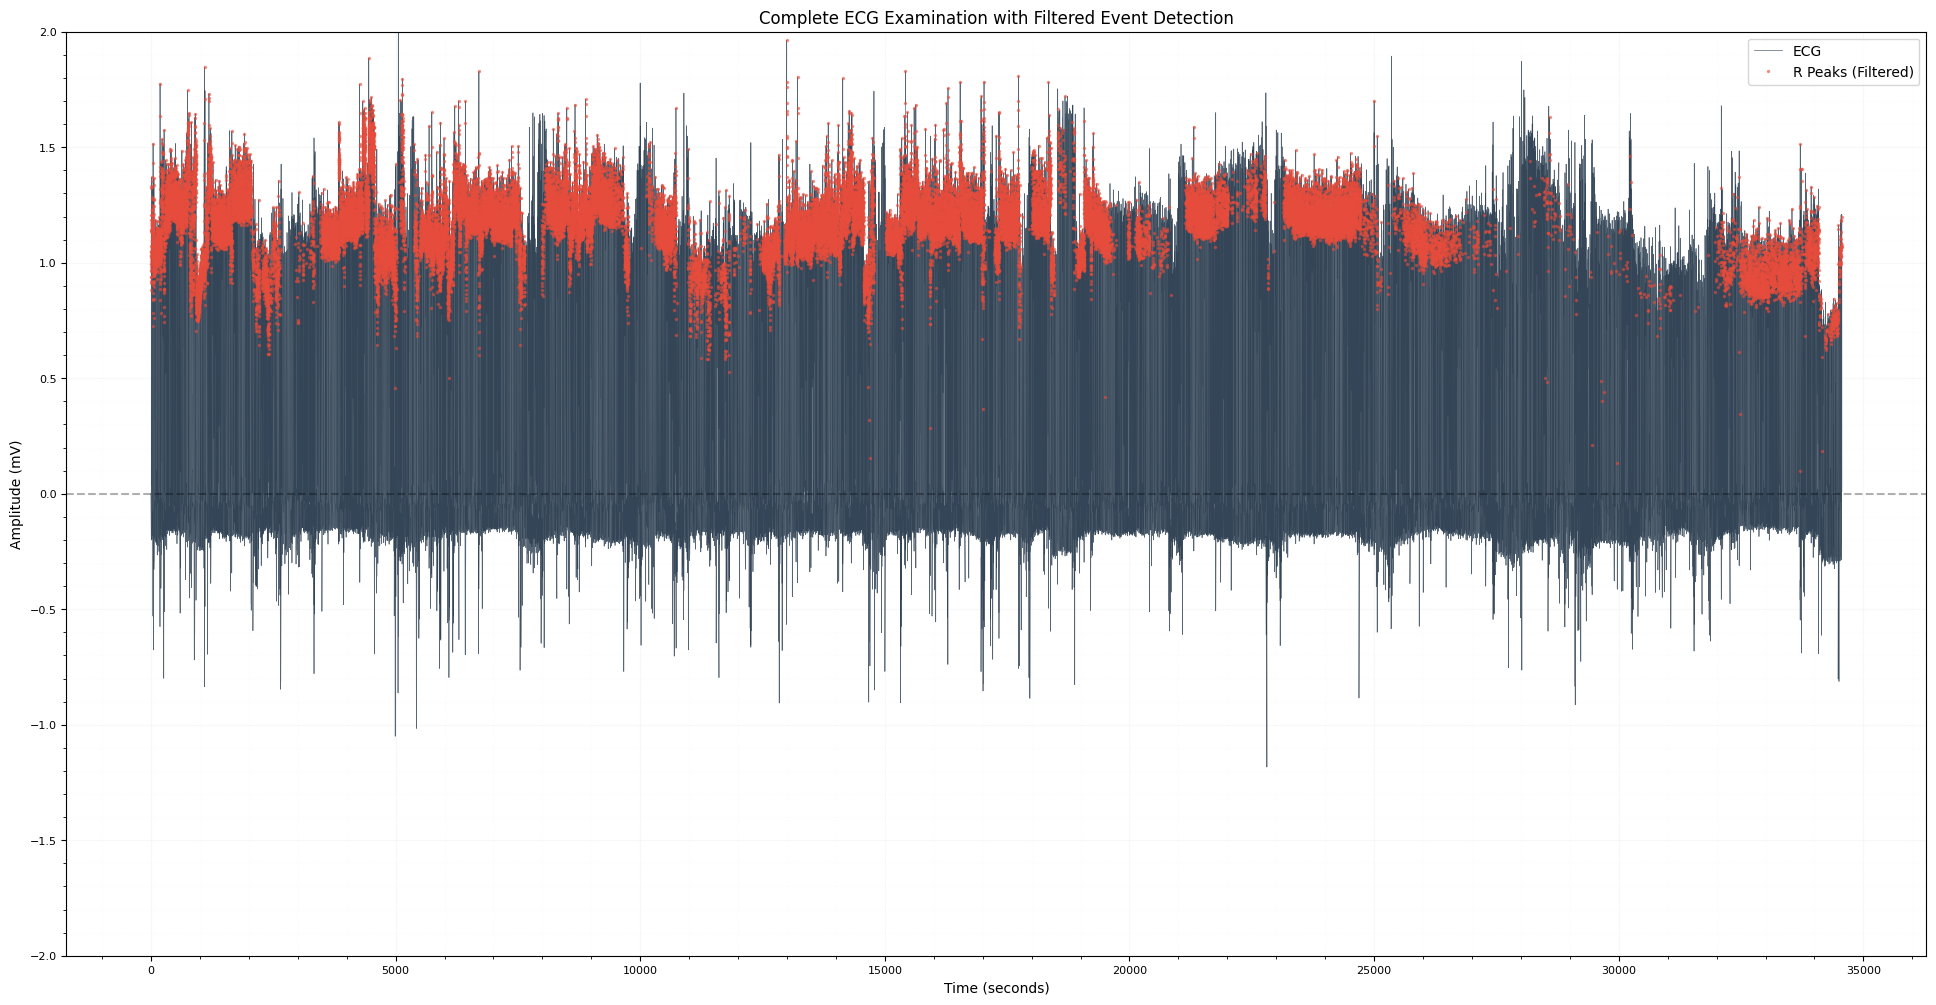

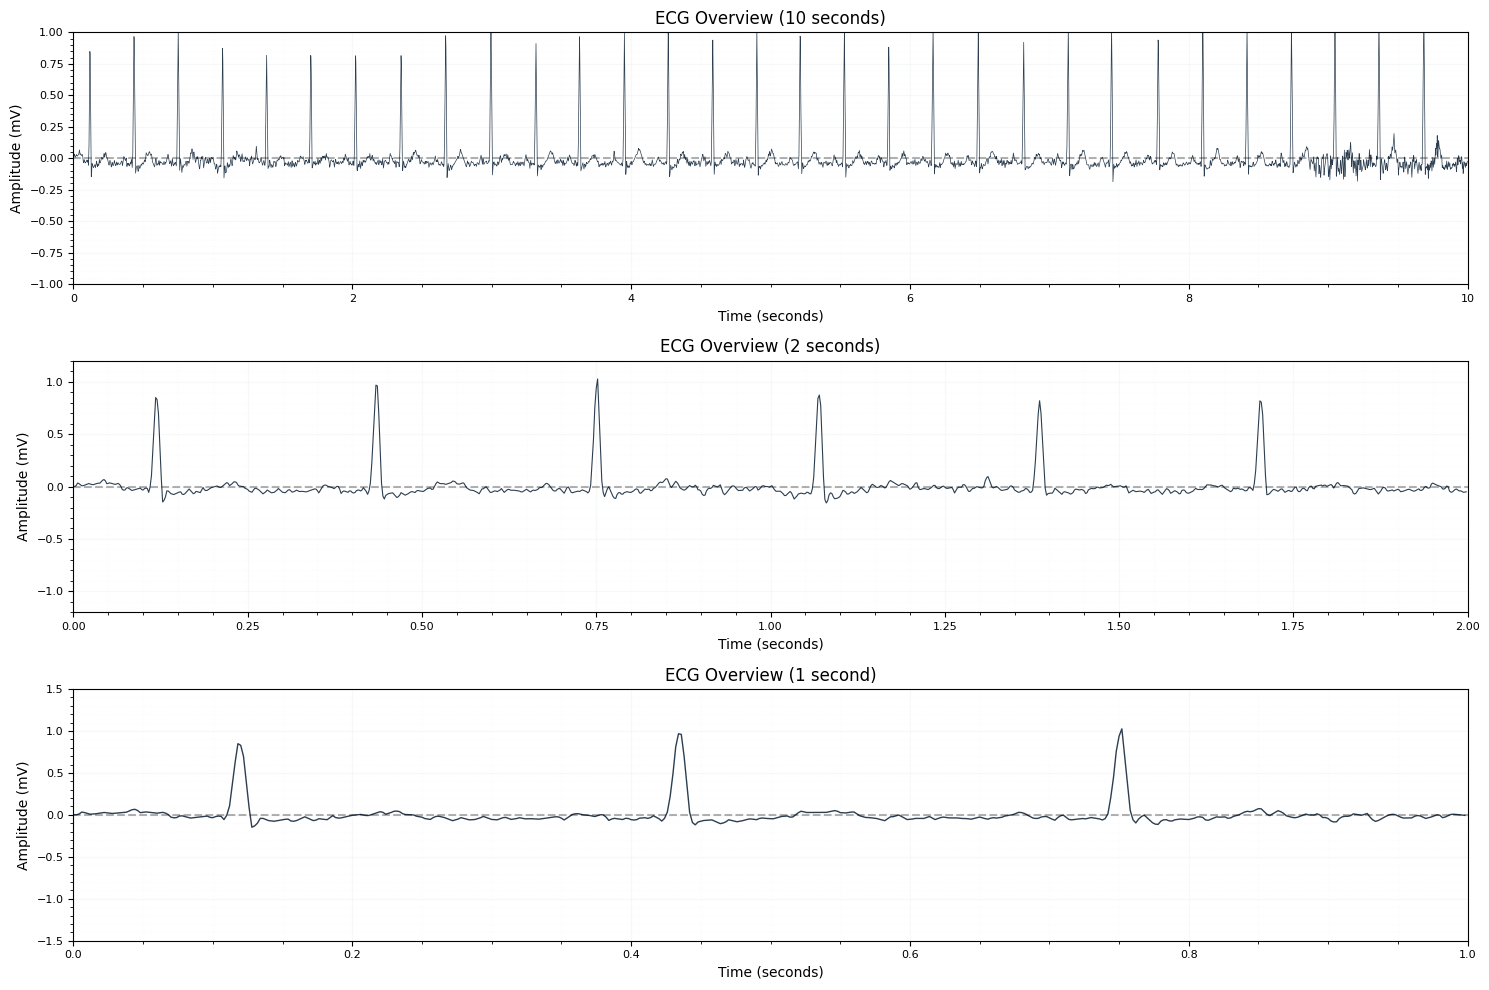

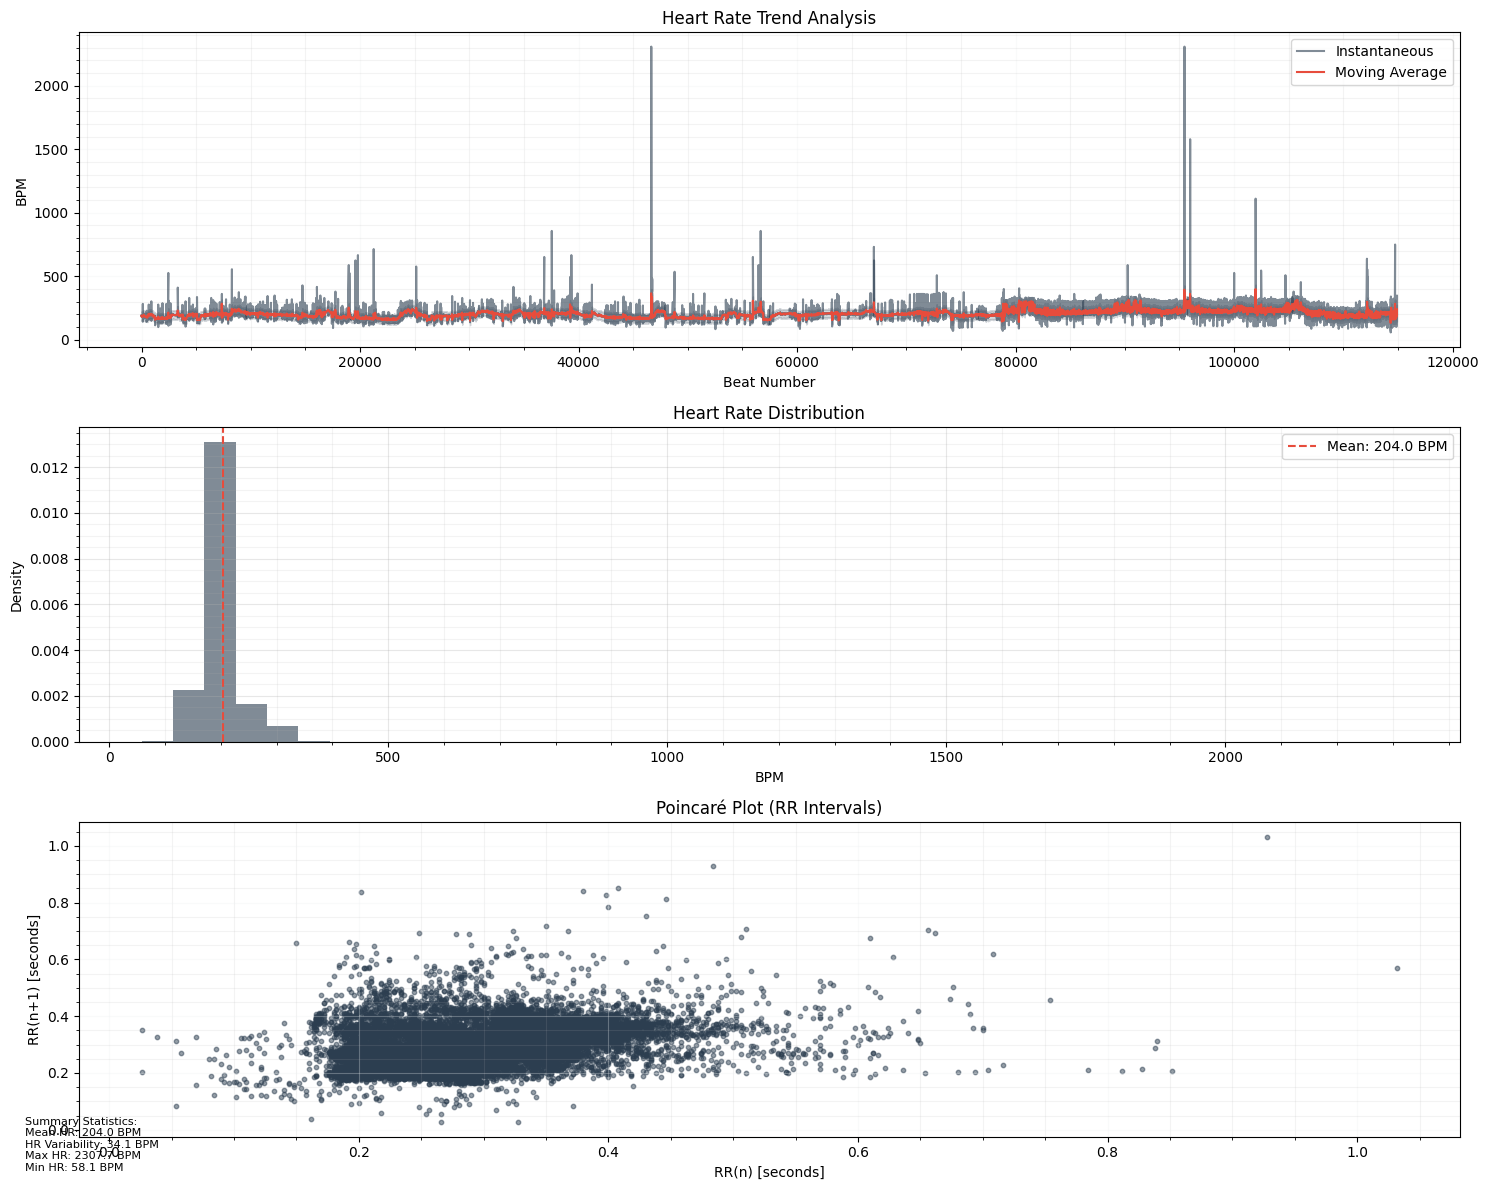

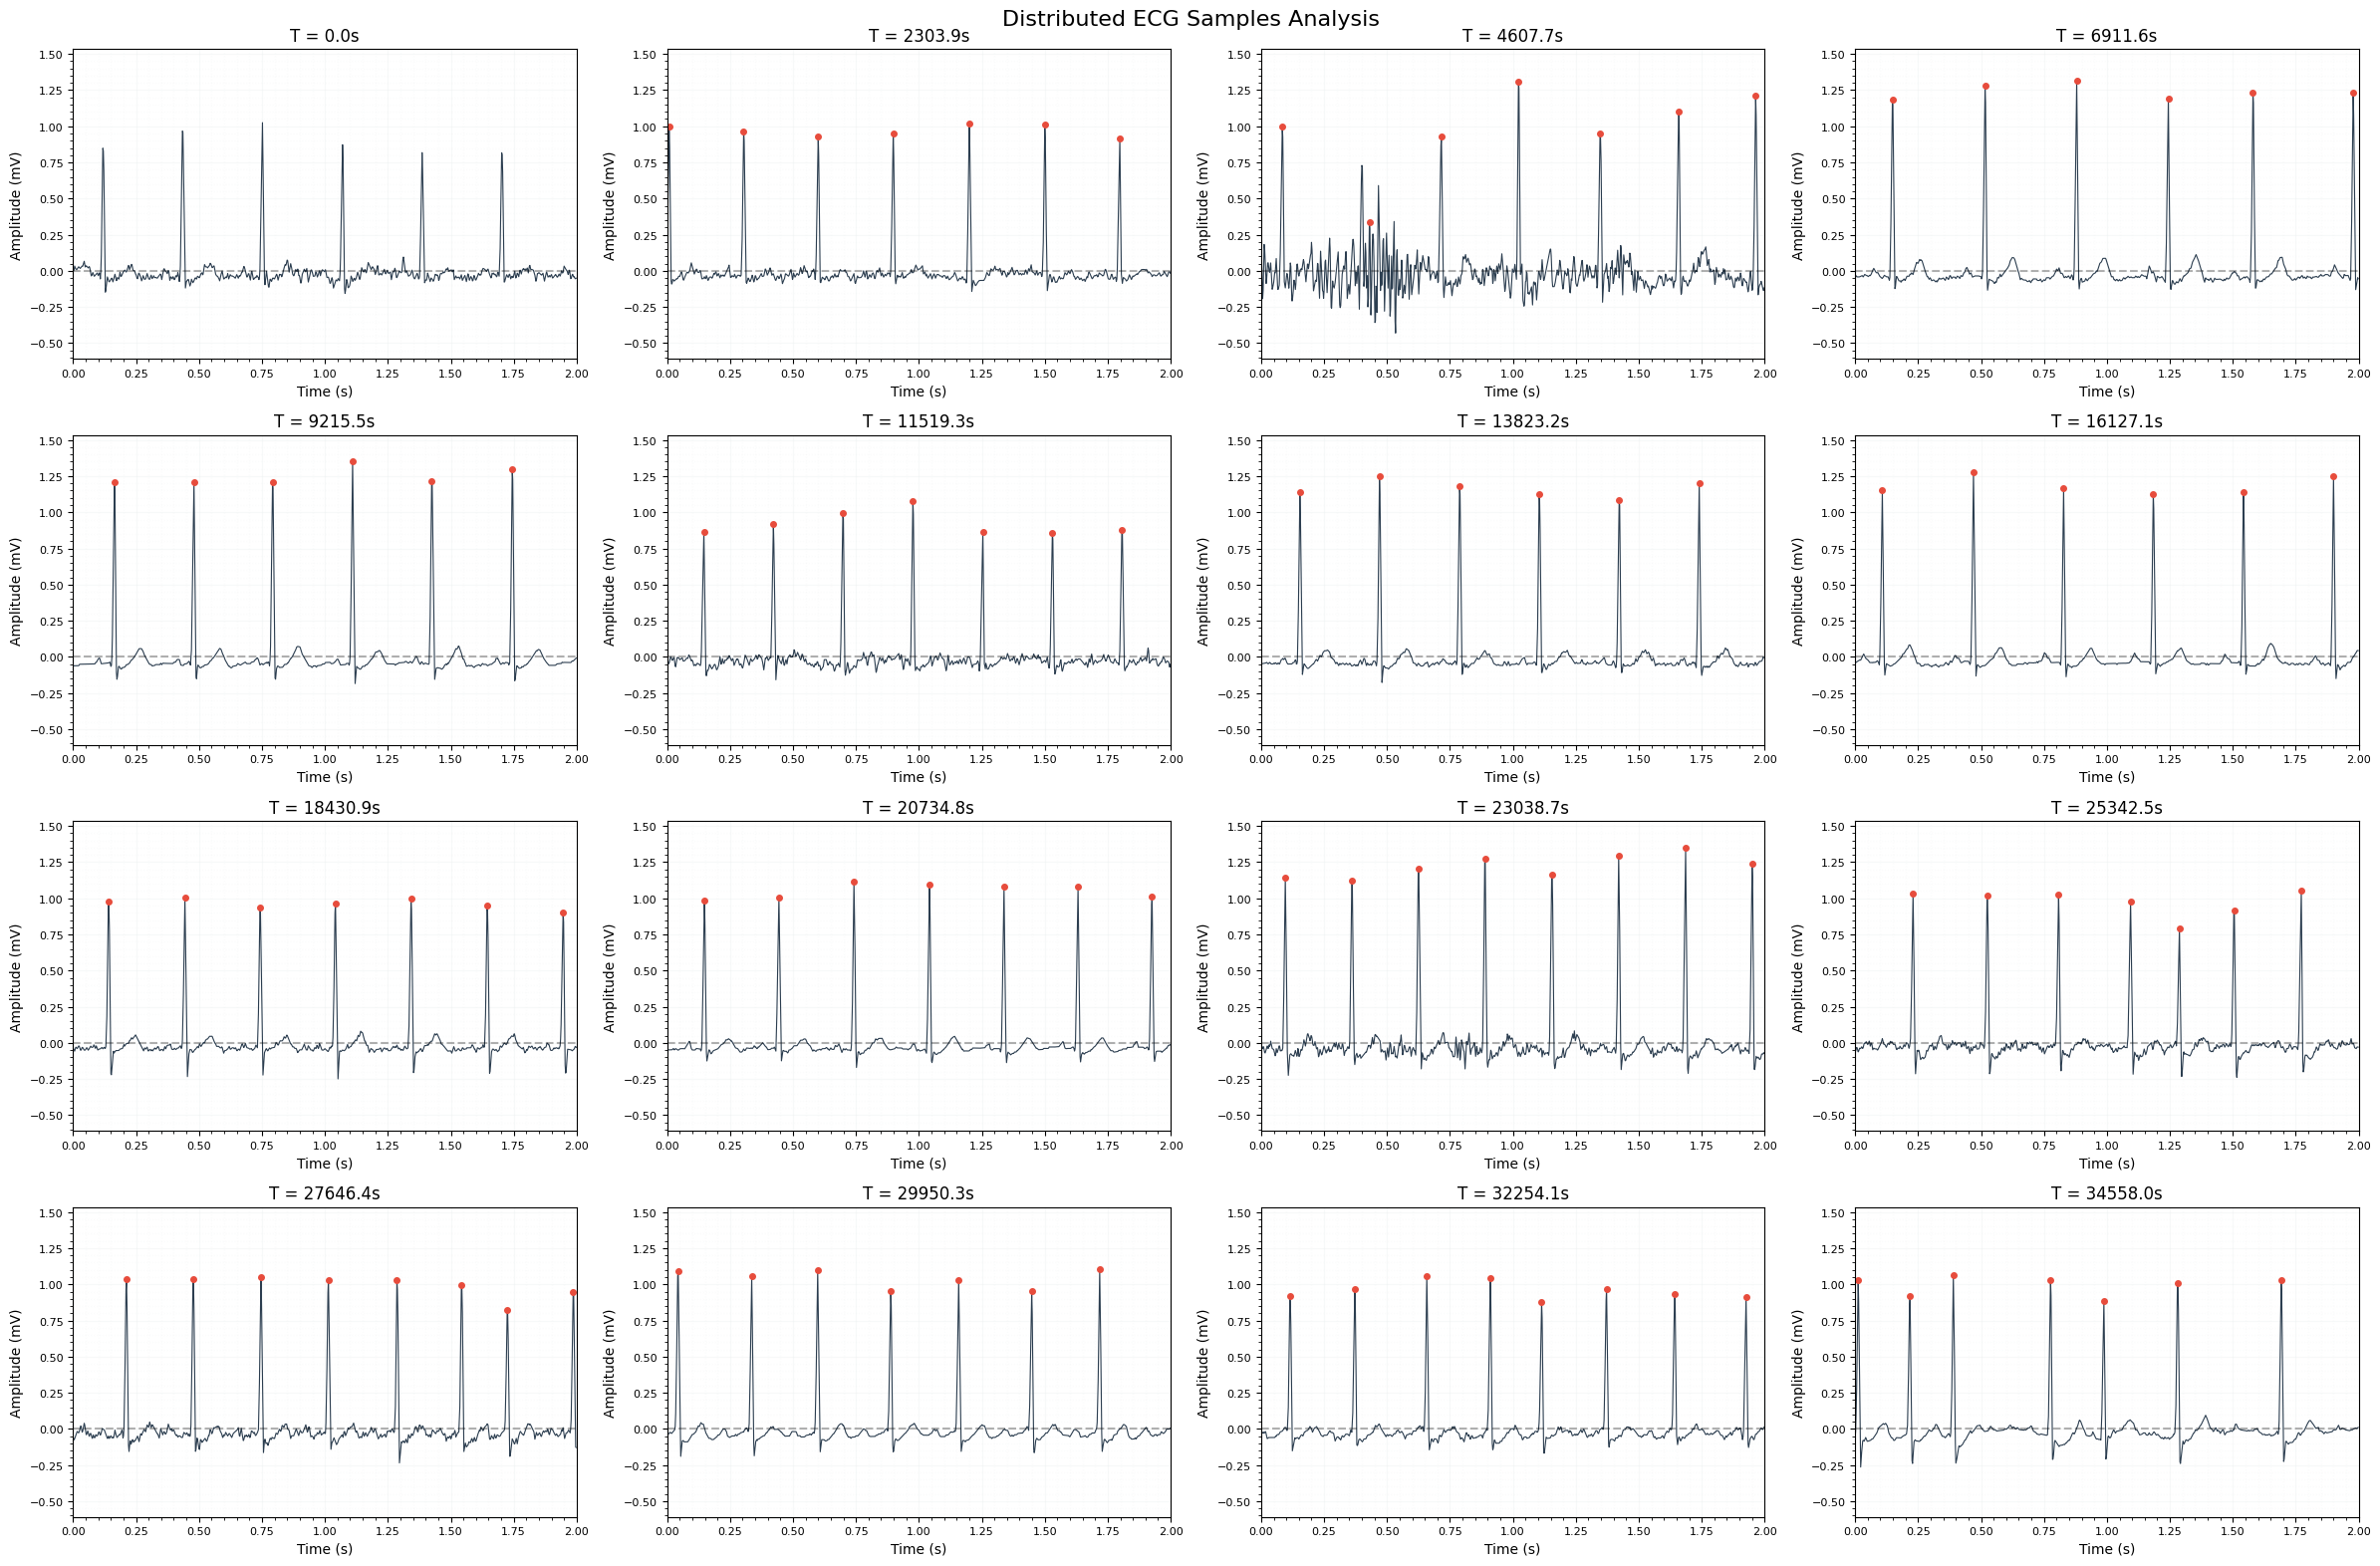

In [47]:
import numpy as np
import wfdb
import os
import matplotlib.pyplot as plt

# Remover a linha que estava causando o erro e usar configurações diretas do matplotlib
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['path.simplify'] = True
plt.rcParams['path.simplify_threshold'] = 0.5
plt.rcParams['figure.figsize'] = (24, 12)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Parâmetros customizados
custom_params = {
    'sampling_rate': 500,
    'styles': {
        'professional': {
            'baseline': {
                'y_min': -2.0,
                'y_max': 2.0,
                'grid_major': 0.5,
                'grid_minor': 0.1,
                'grid_alpha': 0.4,
                'zero_line': True,
                'zero_color': '#000000',
                'zero_alpha': 0.3
            },
            'ecg_color': '#2C3E50',
            'peak_color': '#E74C3C',
            'figsize_full': (24, 12)
        }
    },
    'plot_params': {
        'hr_analysis': {
            'window_size': 15,
            'hist_bins': 40
        },
        'distributed_samples': {
            'window_seconds': 2.0,
            'num_samples': 16,
            'grid_layout': (4, 4)
        }
    }
}

# Carregar os dados
record_path = '/content/pasta/003'
signal, fields = wfdb.rdsamp(record_path)
annotations = wfdb.rdann(record_path, 'qrs')

# Modificar a classe para remover a linha problemática
class ModifiedHolterPlotAnalyzer(HolterPlotAnalyzer):
    def __init__(self, params=None):
        self.params = DEFAULT_PARAMS.copy()
        if params:
            self._update_params(params)

        self._setup_logging()
        self._setup_style(self.params.get('style', 'professional'))
        # Removida a linha plt.style.use('seaborn-whitegrid')

# Criar instância do analisador modificado
analyzer = ModifiedHolterPlotAnalyzer(params=custom_params)

# Diretório de saída
output_dir = '/content/pasta'
os.makedirs(output_dir, exist_ok=True)

# Gerar as análises
try:
    analyzer.plot_all_analyses(
        filtered_data=signal[:, 0],
        peaks=annotations.sample,
        save_dir=output_dir
    )
except Exception as e:
    print(f"Erro ao gerar análises: {str(e)}")


In [48]:
import wfdb
import numpy as np
from scipy import stats

# Default parameters for ECG analysis
DEFAULT_PARAMS = {
    'sampling_rate': 500,
    'lowcut': 1.0,
    'highcut': 30.0,
    'filter_order': 3,
    'peak_detection': {
        'min_distance_factor': 0.4,  # multiplied by sampling_rate
        'height_std_factor': 2,      # multiplied by signal std
        'prominence_factor': 1        # multiplied by signal std
    },
    'rr_validation': {
        'min_rr': 0.4,  # minimum RR interval in seconds (150 bpm)
        'max_rr': 1.5,  # maximum RR interval in seconds (40 bpm)
        'iqr_factor': 1.5  # factor for IQR-based outlier detection
    },
    'quality_thresholds': {
        'min_valid_rr': 0.27,  # minimum valid RR interval in seconds
        'max_valid_rr': 3.0    # maximum valid RR interval in seconds
    },
    'fc_ranges': {
        'severe_bradycardia': {'min': 0, 'max': 50, 'label': 'Bradicardia severa (<50 bpm)'},
        'bradycardia': {'min': 50, 'max': 60, 'label': 'Bradicardia (50-60 bpm)'},
        'normal': {'min': 60, 'max': 100, 'label': 'Normal (60-100 bpm)'},
        'tachycardia': {'min': 100, 'max': 120, 'label': 'Taquicardia (100-120 bpm)'},
        'severe_tachycardia': {'min': 120, 'max': float('inf'), 'label': 'Taquicardia severa (>120 bpm)'}
    }
}

def print_complete_metrics(metrics, params=DEFAULT_PARAMS):
    """Imprime todas as métricas disponíveis de forma organizada."""
    print("\n" + "="*50)
    print("ANÁLISE COMPLETA DO EXAME ECG")
    print("="*50)

    # 1. Métricas Básicas
    print("\n1. MÉTRICAS TEMPORAIS BÁSICAS:")
    print(f"Duração total do exame: {metrics['basic']['duration']/3600:.2f} horas")
    print(f"Total de batimentos: {metrics['basic']['total_beats']:,}")
    print(f"Frequência cardíaca média: {metrics['basic']['mean_hr']:.1f} bpm")
    print(f"Desvio padrão da FC: {metrics['basic']['std_hr']:.1f} bpm")
    print(f"FC mínima: {metrics['basic']['min_hr']:.1f} bpm")
    print(f"FC máxima: {metrics['basic']['max_hr']:.1f} bpm")
    print(f"Variação da FC: {metrics['basic']['hr_range']:.1f} bpm")

    # 2. Métricas de VFC
    print("\n2. VARIABILIDADE DA FREQUÊNCIA CARDÍACA:")
    print(f"RMSSD: {metrics['hrv']['rmssd']:.2f} ms")
    print(f"SDNN: {metrics['hrv']['sdnn']:.2f} ms")
    print(f"NN50: {metrics['hrv']['nn50']}")
    print(f"pNN50: {metrics['hrv']['pnn50']:.2f}%")

    # 3. Métricas Não-lineares
    print("\n3. MÉTRICAS NÃO-LINEARES:")
    print(f"SD1 (Variabilidade de curto prazo): {metrics['nonlinear']['sd1']:.2f} ms")
    print(f"SD2 (Variabilidade de longo prazo): {metrics['nonlinear']['sd2']:.2f} ms")
    print(f"Razão SD1/SD2: {metrics['nonlinear']['sd_ratio']:.3f}")

    # 4. Distribuição da FC
    peaks = metrics['peaks']
    rr_intervals = np.diff(peaks) / params['sampling_rate']
    heart_rates = 60 / rr_intervals

    print("\n4. DISTRIBUIÇÃO DA FREQUÊNCIA CARDÍACA:")
    for range_info in params['fc_ranges'].values():
        count = np.sum((heart_rates >= range_info['min']) & (heart_rates < range_info['max']))
        percentage = (count / len(heart_rates)) * 100
        print(f"{range_info['label']}: {count} batimentos ({percentage:.1f}%)")

    # 5. Estatísticas dos Intervalos RR
    print("\n5. ANÁLISE DOS INTERVALOS RR:")
    print(f"Média: {np.mean(rr_intervals)*1000:.2f} ms")
    print(f"Mediana: {np.median(rr_intervals)*1000:.2f} ms")
    print(f"Desvio Padrão: {np.std(rr_intervals)*1000:.2f} ms")
    print(f"Assimetria: {stats.skew(rr_intervals):.3f}")
    print(f"Curtose: {stats.kurtosis(rr_intervals):.3f}")
    print(f"Intervalo RR mínimo: {np.min(rr_intervals)*1000:.2f} ms")
    print(f"Intervalo RR máximo: {np.max(rr_intervals)*1000:.2f} ms")

    # 6. Análise de Qualidade
    valid_rr = np.logical_and(
        rr_intervals >= params['quality_thresholds']['min_valid_rr'],
        rr_intervals <= params['quality_thresholds']['max_valid_rr']
    )
    quality_index = np.sum(valid_rr) / len(rr_intervals) * 100

    print("\n6. ÍNDICES DE QUALIDADE:")
    print(f"Qualidade dos intervalos RR: {quality_index:.1f}%")
    print(f"Intervalos válidos: {np.sum(valid_rr):,}")
    print(f"Intervalos anormais: {len(rr_intervals) - np.sum(valid_rr):,}")

def analyze_ecg(record_path, params=None):
    """
    Analisa o ECG com parâmetros customizáveis.

    Args:
        record_path: Caminho para o arquivo de registro
        params: Dicionário com parâmetros customizados (opcional)
    """
    # Usar parâmetros default se não fornecidos
    analysis_params = DEFAULT_PARAMS.copy()
    if params:
        analysis_params.update(params)

    # Criar instância do analisador com os parâmetros
    metrics_analyzer = HolterMetricsAnalyzer(params=analysis_params)

    # Carregar dados do ECG
    record = wfdb.rdrecord(record_path)
    data = record.p_signal[:, 0]  # Primeiro canal

    # Analisar sinal
    metrics = metrics_analyzer.analyze_signal(data)

    if metrics is not None:
        # Imprimir todas as métricas
        print_complete_metrics(metrics, params=analysis_params)
    else:
        print("Erro na análise do sinal")

if __name__ == "__main__":
    # Exemplo de uso com parâmetros customizados
    custom_params = {
        'sampling_rate': 500,
        'peak_detection': {
            'min_distance_factor': 0.3,  # Mais sensível à detecção de picos
            'height_std_factor': 1.8     # Menor threshold para altura dos picos
        },
        'quality_thresholds': {
            'min_valid_rr': 0.25,  # Mais permissivo com intervalos RR curtos
            'max_valid_rr': 3.5    # Mais permissivo com intervalos RR longos
        }
    }

    record_path = '/content/pasta/003'
    analyze_ecg(record_path, params=custom_params)


ANÁLISE COMPLETA DO EXAME ECG

1. MÉTRICAS TEMPORAIS BÁSICAS:
Duração total do exame: 9.60 horas
Total de batimentos: 80,233
Frequência cardíaca média: 108.0 bpm
Desvio padrão da FC: 8.5 bpm
FC mínima: 85.0 bpm
FC máxima: 135.1 bpm
Variação da FC: 50.1 bpm

2. VARIABILIDADE DA FREQUÊNCIA CARDÍACA:
RMSSD: 31.03 ms
SDNN: 30.56 ms
NN50: 2248
pNN50: 11.27%

3. MÉTRICAS NÃO-LINEARES:
SD1 (Variabilidade de curto prazo): 21.94 ms
SD2 (Variabilidade de longo prazo): 30.56 ms
Razão SD1/SD2: 0.718

4. DISTRIBUIÇÃO DA FREQUÊNCIA CARDÍACA:
Bradicardia severa (<50 bpm): 0 batimentos (0.0%)
Bradicardia (50-60 bpm): 9 batimentos (0.0%)
Normal (60-100 bpm): 7519 batimentos (9.4%)
Taquicardia (100-120 bpm): 17933 batimentos (22.4%)
Taquicardia severa (>120 bpm): 54771 batimentos (68.3%)

5. ANÁLISE DOS INTERVALOS RR:
Média: 430.75 ms
Mediana: 354.00 ms
Desvio Padrão: 152.81 ms
Assimetria: 1.336
Curtose: 0.968
Intervalo RR mínimo: 300.00 ms
Intervalo RR máximo: 1146.00 ms

6. ÍNDICES DE QUALIDADE:
Qual